## Generate flux distribution PDFs
This notebooks loads in data from ERA5 + GCM precomputed fluxes (using their respective notebooks)

In [1]:
import matplotlib.pyplot as plt 

plt.rcParams.update({
    'font.family':"sans-serif",
    'font.style':'normal',
    'font.size':16.5,
    'figure.figsize':(8,8)
})

In [2]:
import xarray as xr 
import numpy as np 
import os 
FIGDIR = '../../figures'
DATADIR = '../../data'
exp = 'AD99 c0=0 (include unbroken)'
expcode = 'never_include_unbroken_1year'
ERA5_DATASET = f"/scratch/users/robcking/era5_{expcode}.nc"
GCM_DATASET = f"/scratch/users/robcking/mima_gwf_{expcode}.nc"

fluxes = ['gw_flux_eastward','gw_flux_westward','gw_flux_northward','gw_flux_southward','z']

ds_era5 = xr.open_dataset(ERA5_DATASET)
ds_gcm = xr.open_dataset(GCM_DATASET)

ds_era5 = ds_era5[fluxes]
ds_gcm = ds_gcm[fluxes]

In [3]:
from ad99py.masks import mask_dataset
BASINS = ['southern_ocean']
basin_title = "(Southern Ocean)"
# can also mask by basin by passing a "basin"
ds_era5 = mask_dataset(ds_era5,dir=DATADIR,basins=BASINS)
ds_gcm = mask_dataset(ds_gcm,dir=DATADIR,basins=BASINS)

In [4]:
ds_era5 = ds_era5.transpose('time','points','level')
ds_gcm = ds_gcm.transpose('time','points','level')

In [5]:
era5_lat = np.broadcast_to(ds_era5.latitude.data[None,:,None],ds_era5.z.shape)
gcm_lat = np.broadcast_to(ds_gcm.latitude.data[None,:,None],ds_gcm.z.shape)

In [6]:
def net(ds):
    return np.sqrt((ds.gw_flux_eastward + ds.gw_flux_westward)**2 + (ds.gw_flux_northward + ds.gw_flux_southward)**2)

def total(ds):
    return np.abs(ds.gw_flux_eastward ) + np.abs(ds.gw_flux_westward ) + np.abs(ds.gw_flux_southward ) + np.abs(ds.gw_flux_northward )

net_era5 = net(ds_era5)
net_gcm = net(ds_gcm)
total_era5 = total(ds_era5)
total_gcm = total(ds_gcm)

### Loon

In [7]:
from ad99py.loon import loon_data
LOON_DATA = loon_data(path='../../data/loon')
LOON_DATA.keys()

dict_keys(['u_flux_ntv', 'u_flux_ptv', 'v_flux_ntv', 'v_flux_ptv', 'u_flux_abs', 'v_flux_abs', 'u_flux_net', 'v_flux_net', 'net_flux', 'abs_flux'])

### unravel and flatten ERA5

In [8]:
def filter_scale(fluxes):
    fluxes = np.abs(fluxes)
    fluxes = fluxes[fluxes > 0]
    return fluxes*1000

In [9]:
def plot_mass(era5,gcm,loon=None,ax=None):
    if ax is None:
        _,ax = plt.subplots()
    bin_edges = np.linspace(0,10,50)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])*0.5
    gcm_hist, _ = np.histogram(np.abs(gcm),bins=bin_edges,density=True)
    era5_hist,_ = np.histogram(np.abs(era5),bins=bin_edges,density=True)
    dx = bin_edges[1] -bin_edges[0]
    gcm_hist *= dx
    era5_hist *= dx
    ax.bar(bin_centers,era5_hist,width=dx,label='ERA5',color='C0',alpha=0.3)
    ax.bar(bin_centers,gcm_hist,width=dx,label='GCM',color='C1',alpha=0.3)
    if loon:
        loon_hist, _ = np.histogram(np.abs(LOON_DATA[loon]),bins=bin_edges,density=True)
        loon_hist *= dx
        ax.bar(bin_centers,loon_hist,width=dx,label='Loon',color='red',alpha=0.3)
    ax.set_xlabel("Momentum Flux (mPa)")
    ax.set_ylabel("Probability")
    ax.legend()
    ax.set_yscale('log')
    return ax

def plot_density(era5,gcm,loon=None,ax=None):
    if ax is None:
        _,ax = plt.subplots()
    bin_edges = np.linspace(0,10,100)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])*0.5
    gcm_hist, _ = np.histogram(np.abs(gcm),bins=bin_edges,density=True)
    era5_hist,_ = np.histogram(np.abs(era5),bins=bin_edges,density=True)
    ax.plot(bin_centers,gcm_hist,label='GCM',color='C1')
    ax.plot(bin_centers,era5_hist,label='ERA5',color='C0')
    if loon:
        loon_hist, _ = np.histogram(np.abs(LOON_DATA[loon]),bins=bin_edges,density=True)
        ax.plot(bin_centers,loon_hist,label='Loon',color='red',linestyle='--')
    ax.set_xlabel("Momentum Flux (mPa)")
    ax.set_ylabel("Probability Density")
    ax.legend()
    return ax

def plot_density_ylog(era5,gcm,loon=None,ax=None):
    if ax is None:
        _, ax = plt.subplots()
    bin_edges = np.linspace(0,10,100)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])*0.5
    gcm_hist, _ = np.histogram(np.abs(gcm),bins=bin_edges,density=True)
    era5_hist,_ = np.histogram(np.abs(era5),bins=bin_edges,density=True)
    ax.plot(bin_centers,gcm_hist,label='GCM',color='C1')
    ax.plot(bin_centers,era5_hist,label='ERA5',color='C0')
    if loon:
        loon_hist, _ = np.histogram(np.abs(LOON_DATA[loon]),bins=bin_edges,density=True)
        ax.plot(bin_centers,loon_hist,label='Loon',color='red',linestyle='--')
    ax.set_xlabel("Momentum Flux (mPa)")
    ax.set_ylabel("Probability Density")
    ax.legend()
    ax.set_yscale('log')
    return ax

def plot_logx_density(era5,gcm,loon=None,ax=None):
    if ax is None:
        _,ax = plt.subplots()
    bin_edges = np.linspace(-3,3,100)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])*0.5
    gcm_hist, _ = np.histogram(np.log10(np.abs(gcm)),bins=bin_edges,density=True)
    era5_hist,_ = np.histogram(np.log10(np.abs(era5)),bins=bin_edges,density=True)
    ax.plot(bin_centers,gcm_hist,label='GCM',color='C1')
    ax.plot(bin_centers,era5_hist,label='ERA5',color='C0')
    if loon:
        loon_hist, _ = np.histogram(np.log10(np.abs(LOON_DATA[loon])),bins=bin_edges,density=True)
        ax.plot(bin_centers,loon_hist,label='Loon',color='red',linestyle='--')
    ax.set_xlabel("Log10 of Momentum Flux in mPa")
    ax.set_ylabel("Probability Density")
    ax.legend()
    return ax

## Plot for all different combos:  


In [10]:
LEVEL = 50#hPa 

eastward

In [11]:
era5_eastward_lvl = ds_era5.gw_flux_eastward.sel(level=LEVEL).data.ravel()
gcm_eastward_lvl = ds_gcm.gw_flux_eastward.sel(level=LEVEL).data.ravel()
era5_eastward_lvl = filter_scale(era5_eastward_lvl)
gcm_eastward_lvl= filter_scale(gcm_eastward_lvl)

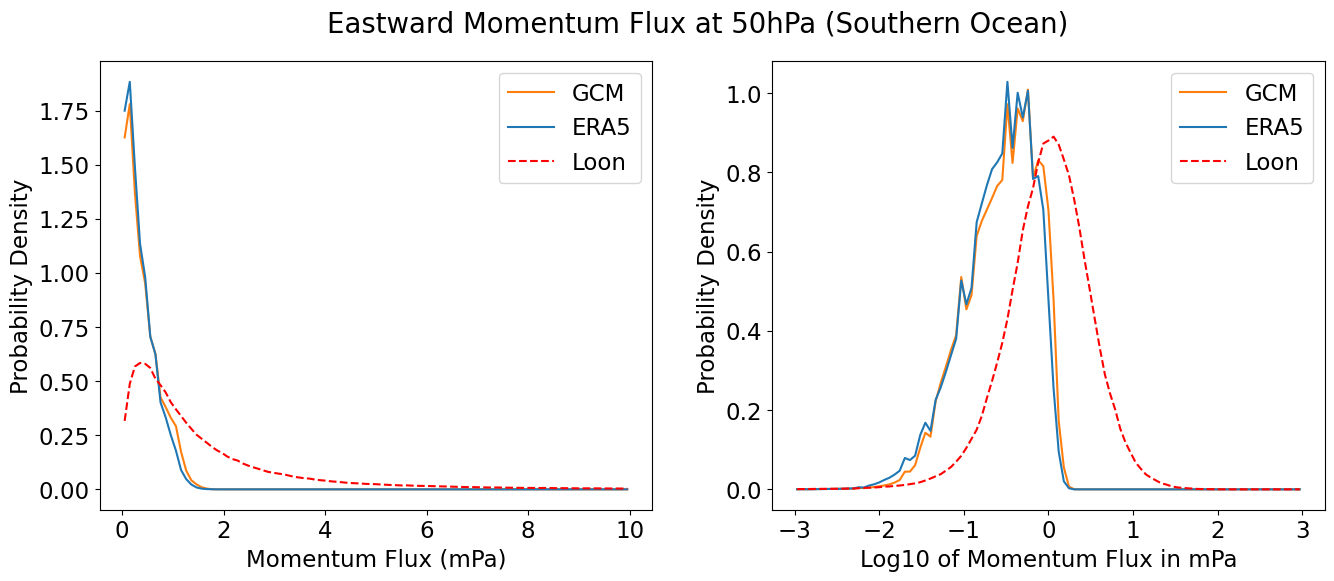

In [12]:
fig,axs = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout(pad=2.4)
axs = axs.ravel()
fig.suptitle(f"Eastward Momentum Flux at {LEVEL}hPa {basin_title}")
# plot_mass(era5_eastward_lvl,gcm_eastward_lvl,loon='u_flux_ptv',ax=axs[0])
plot_density(era5_eastward_lvl,gcm_eastward_lvl,loon='u_flux_ptv',ax=axs[0])
# plot_density_ylog(era5_eastward_lvl,gcm_eastward_lvl,loon='u_flux_ptv',ax=axs[2])
plot_logx_density(era5_eastward_lvl,gcm_eastward_lvl,loon='u_flux_ptv',ax=axs[1])

fig.savefig(os.path.join(FIGDIR,f'{expcode}_uptv_fluxes_{LEVEL}_{'_'.join(BASINS) if BASINS else 'all'}.png'))


westward

In [13]:
era5_westward_lvl = ds_era5.gw_flux_westward.sel(level=LEVEL).data.ravel()
gcm_westward_lvl = ds_gcm.gw_flux_westward.sel(level=LEVEL).data.ravel()
era5_westward_lvl = filter_scale(era5_westward_lvl)
gcm_westward_lvl= filter_scale(gcm_westward_lvl)


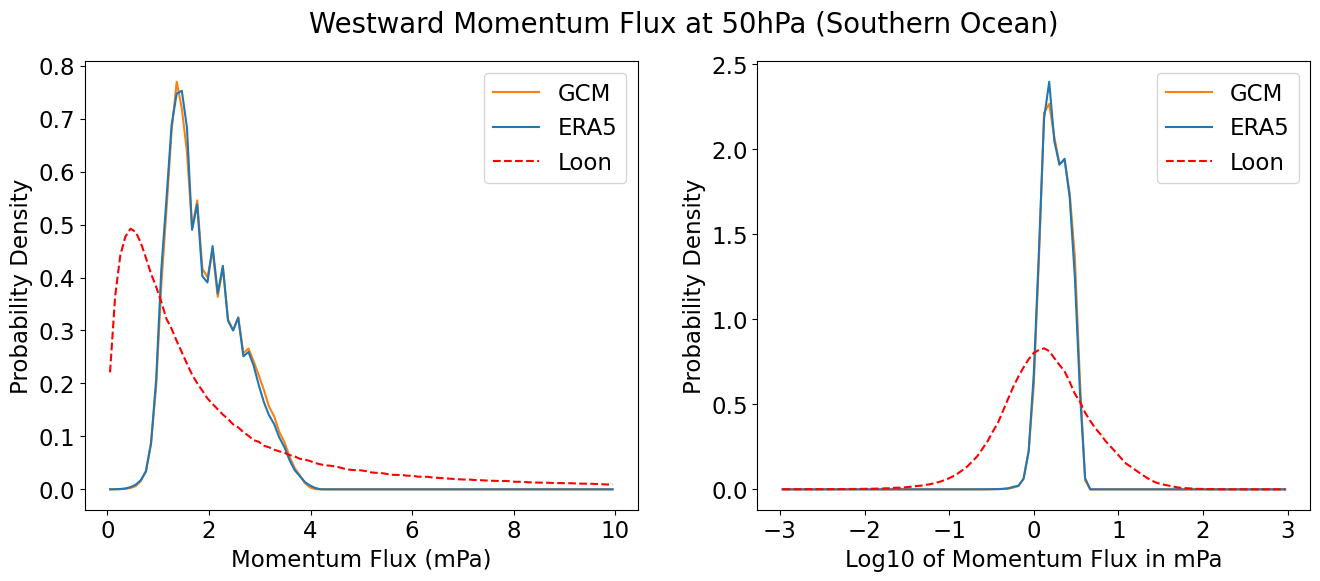

In [14]:
fig,axs = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout(pad=2.4)
axs = axs.ravel()
fig.suptitle(f"Westward Momentum Flux at {LEVEL}hPa {basin_title}")

plot_density(era5_westward_lvl,gcm_westward_lvl,loon='u_flux_ntv',ax=axs[0])
plot_logx_density(era5_westward_lvl,gcm_westward_lvl,loon='u_flux_ntv',ax=axs[1])

fig.savefig(os.path.join(FIGDIR,f'{expcode}_untv_fluxes_{LEVEL}_{'_'.join(BASINS) if BASINS else 'all'}.png'))


northward

In [15]:
era5_northward_lvl = ds_era5.gw_flux_northward.sel(level=LEVEL).data.ravel()
gcm_northward_lvl = ds_gcm.gw_flux_northward.sel(level=LEVEL).data.ravel()
era5_northward_lvl = filter_scale(era5_northward_lvl)
gcm_northward_lvl= filter_scale(gcm_northward_lvl)


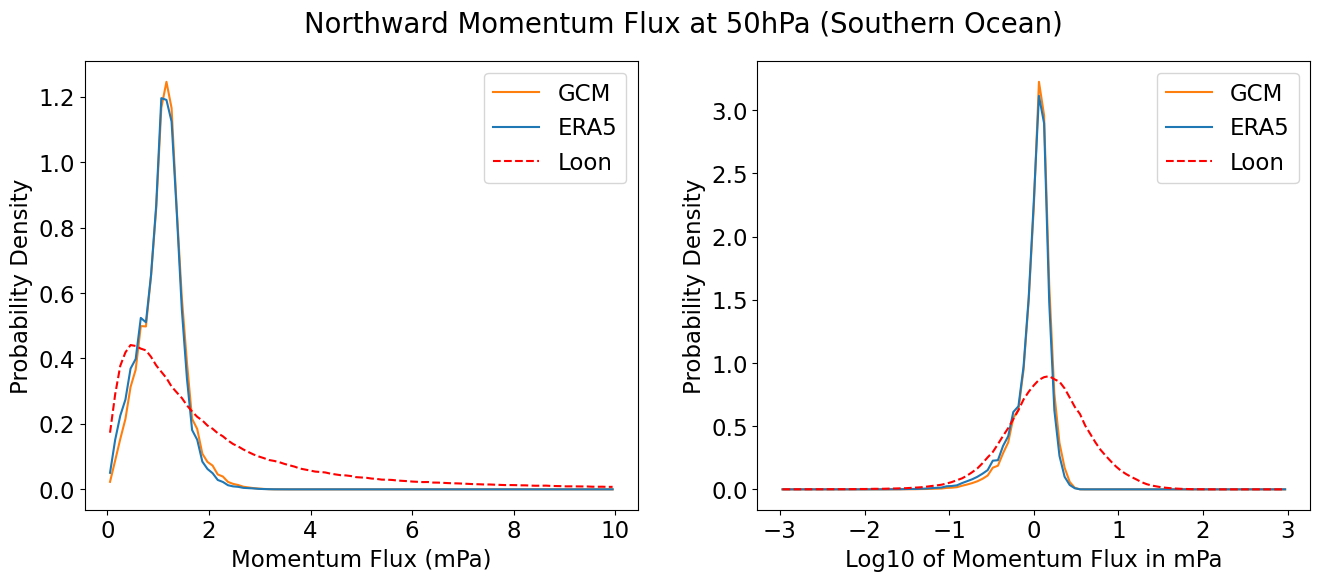

In [16]:
fig,axs = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout(pad=2.4)
axs = axs.ravel()
fig.suptitle(f"Northward Momentum Flux at {LEVEL}hPa {basin_title}")

plot_density(era5_northward_lvl,gcm_northward_lvl,loon='v_flux_ptv',ax=axs[0])
plot_logx_density(era5_northward_lvl,gcm_northward_lvl,loon='v_flux_ptv',ax=axs[1])

fig.savefig(os.path.join(FIGDIR,f'{expcode}_vptv_fluxes_{LEVEL}_{'_'.join(BASINS) if BASINS else 'all'}.png'))


southward

In [17]:
era5_southward_lvl = ds_era5.gw_flux_southward.sel(level=LEVEL).data.ravel()
gcm_southward_lvl = ds_gcm.gw_flux_southward.sel(level=LEVEL).data.ravel()
era5_southward_lvl = filter_scale(era5_southward_lvl)
gcm_southward_lvl= filter_scale(gcm_southward_lvl)


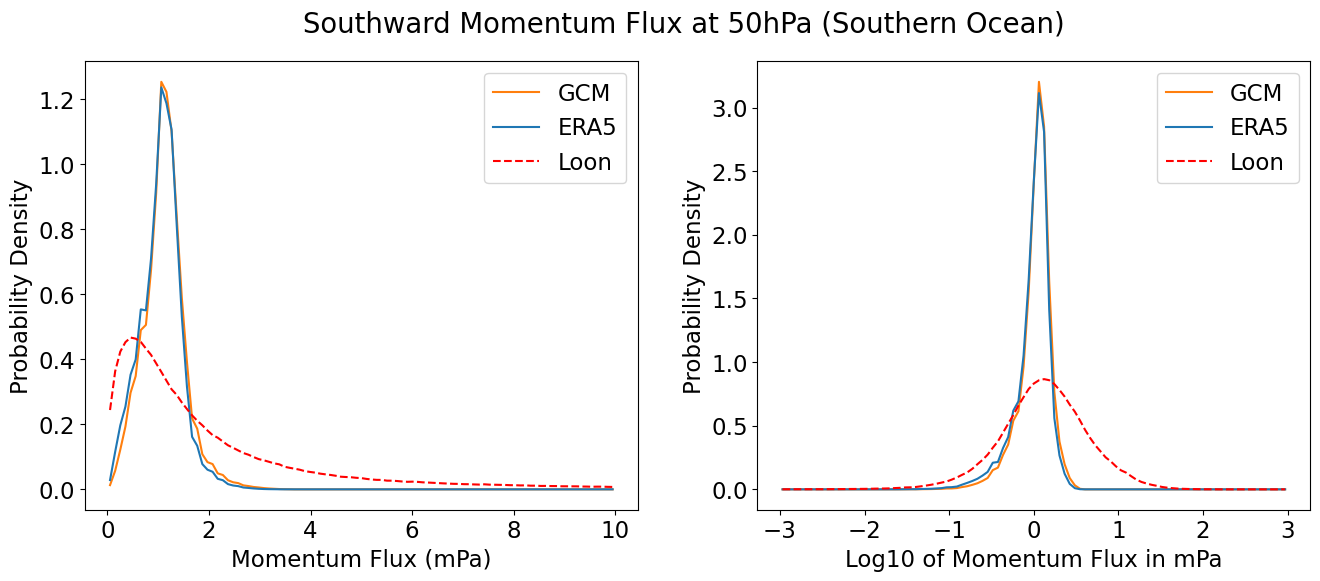

In [18]:
fig,axs = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout(pad=2.4)
axs = axs.ravel()
fig.suptitle(f"Southward Momentum Flux at {LEVEL}hPa {basin_title}")

plot_density(era5_southward_lvl,gcm_southward_lvl,loon='v_flux_ntv',ax=axs[0])
plot_logx_density(era5_southward_lvl,gcm_southward_lvl,loon='v_flux_ntv',ax=axs[1])

fig.savefig(os.path.join(FIGDIR,f'{expcode}_vntv_fluxes_{LEVEL}_{'_'.join(BASINS) if BASINS else 'all'}.png'))


net

In [19]:
era5_net_lvl = net_era5.sel(level=LEVEL).data.ravel()
gcm_net_lvl = net_gcm.sel(level=LEVEL).data.ravel()
era5_net_lvl = filter_scale(era5_net_lvl)
gcm_net_lvl= filter_scale(gcm_net_lvl)


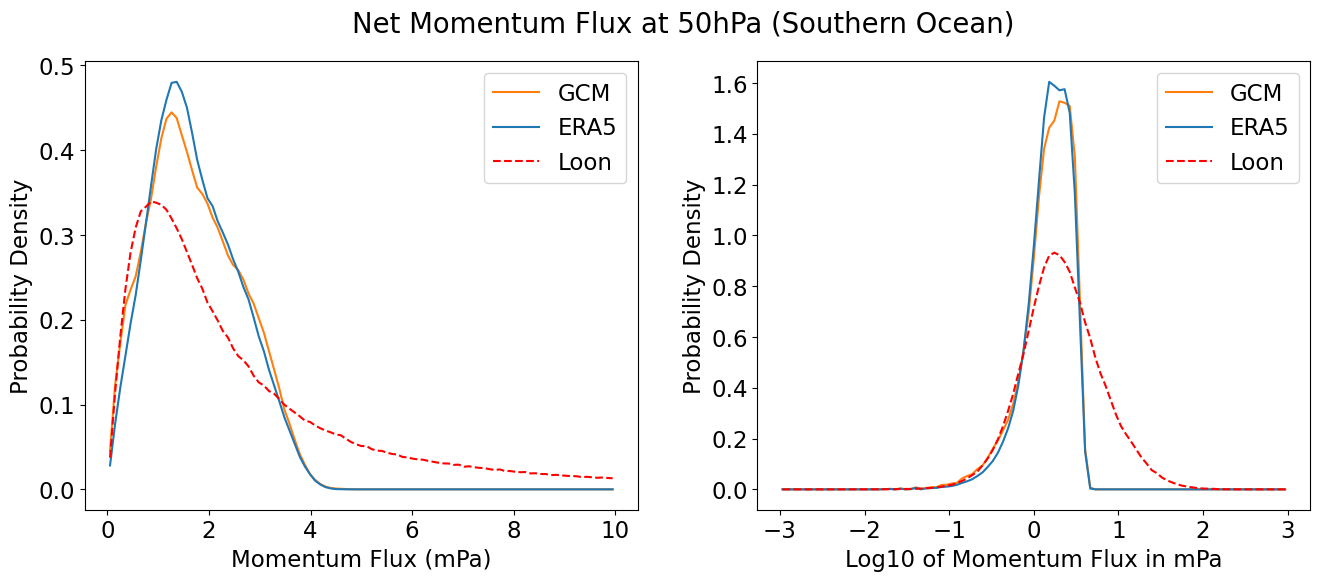

In [20]:
fig,axs = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout(pad=2.4)
axs = axs.ravel()
fig.suptitle(f"Net Momentum Flux at {LEVEL}hPa {basin_title}")

plot_density(era5_net_lvl,gcm_net_lvl,loon='net_flux',ax=axs[0])
plot_logx_density(era5_net_lvl,gcm_net_lvl,loon='net_flux',ax=axs[1])

fig.savefig(os.path.join(FIGDIR,f'{expcode}_net_fluxes_{LEVEL}_{'_'.join(BASINS) if BASINS else 'all'}.png'))


total

In [21]:
era5_abs_lvl = total_era5.sel(level=LEVEL).data.ravel()
gcm_abs_lvl = total_gcm.sel(level=LEVEL).data.ravel()
era5_abs_lvl = filter_scale(era5_abs_lvl)
gcm_abs_lvl= filter_scale(gcm_abs_lvl)


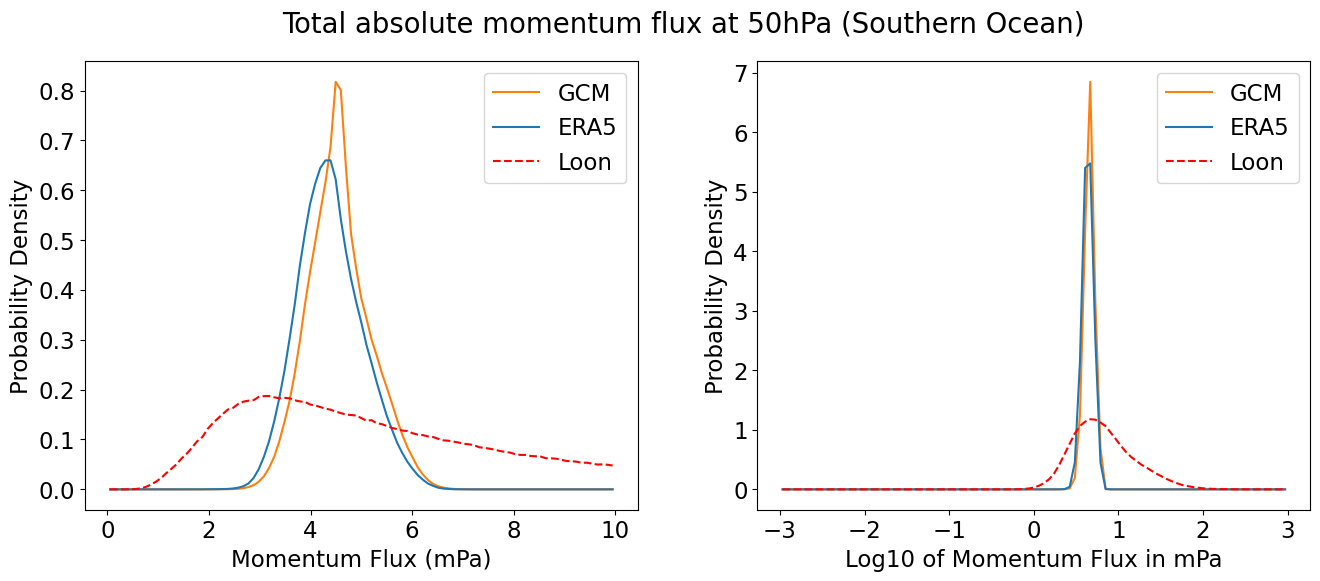

In [22]:
fig,axs = plt.subplots(1,2,figsize=(14,6))
fig.tight_layout(pad=2.4)
axs = axs.ravel()
fig.suptitle(f"Total absolute momentum flux at {LEVEL}hPa {basin_title}")

plot_density(era5_abs_lvl,gcm_abs_lvl,loon='abs_flux',ax=axs[0])
plot_logx_density(era5_abs_lvl,gcm_abs_lvl,loon='abs_flux',ax=axs[1])

fig.savefig(os.path.join(FIGDIR,f'{expcode}_total_fluxes_{LEVEL}_{'_'.join(BASINS) if BASINS else 'all'}.png'))
